In [1]:

# Part 1: 기본 설정 및 라이브러리 임포트
import os
import glob
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


In [2]:
# GPU가 사용 가능한지 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import numpy as np
from PIL import Image
from tensorflow.keras import layers


# 데이터 전처리 함수 정의

# --- 2-1. 이미지 로드 및 기본 전처리 ---
def load_and_preprocess_image(path, size=(256, 256)):
    img = Image.open(path).convert('L').resize(size, Image.LANCZOS)
    return np.array(img, dtype=np.float32) / 255.0

# --- 2-2. 데이터 증강 ---
data_augmentation_pipeline = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
], name="geometric_augmentation")

def augment_brightness_contrast(image):
    image_with_channel = image[..., tf.newaxis]
    image_aug = tf.image.random_brightness(image_with_channel, max_delta=0.15)
    image_aug = tf.image.random_contrast(image_aug, lower=0.8, upper=1.2)
    return tf.squeeze(image_aug)

# --- 2-3. 노이즈 추가 함수 ---
def add_noise_snr_np(image, snr_db):
    signal_power = np.mean(np.square(image))
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_sigma = np.sqrt(noise_power)
    noise = np.random.normal(0, noise_sigma, image.shape).astype(np.float32)
    return np.clip(image + noise, 0.0, 1.0).astype(np.float32)

def add_salt_and_pepper_noise(image, amount=0.05):
    noisy_image = np.copy(image)
    # Salt
    num_salt = np.ceil(amount * image.size * 0.5).astype(int)
    coords = tuple(np.random.randint(0, i-1, num_salt) for i in image.shape if i > 1)
    if coords and coords[0].size > 0: noisy_image[coords] = 1.0
    # Pepper
    num_pepper = np.ceil(amount * image.size * 0.5).astype(int)
    coords = tuple(np.random.randint(0, i-1, num_pepper) for i in image.shape if i > 1)
    if coords and coords[0].size > 0: noisy_image[coords] = 0.0
    return noisy_image

def add_burst_noise(image, burst_size_factor=0.2, intensity=0.8):
    noisy_image = np.copy(image)
    h, w = image.shape
    burst_h, burst_w = int(h * burst_size_factor), int(w * burst_size_factor)
    if h <= burst_h or w <= burst_w: return noisy_image
    start_y = np.random.randint(0, h - burst_h)
    start_x = np.random.randint(0, w - burst_w)
    burst_noise = np.random.normal(0, intensity, (burst_h, burst_w)).astype(np.float32)
    burst_area = noisy_image[start_y:start_y+burst_h, start_x:start_x+burst_w]
    noisy_area = np.clip(burst_area + burst_noise, 0.0, 1.0)
    noisy_image[start_y:start_y+burst_h, start_x:start_x+burst_w] = noisy_area
    return noisy_image

print("All preprocessing functions are defined.")

All preprocessing functions are defined.


2025-10-02 13:17:39.315621: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-02 13:17:39.315645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-02 13:17:39.315650: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-02 13:17:39.315827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-02 13:17:39.316131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Part 3: 파일 데이터 전처리 및 로드
import glob
from tqdm import tqdm

# --- 3-1. 원본 이미지 경로 정의 및 로드 ---
all_image_paths = ['data/mona_lisa.jpg'] + sorted(glob.glob('data/sample*.jpg'))
class_names = [f"Mona Lisa {i} ({'Original' if i==0 else f'Parody_{i}'})" for i in range(len(all_image_paths))]
try:
    original_images = [load_and_preprocess_image(p) for p in all_image_paths]
    print(f"Successfully loaded {len(original_images)} images for {len(class_names)} classes.")
except Exception as e:
    print(f"Error during image loading: {e}")

# --- 3-2. 최종 데이터셋 생성 함수 (조건부 입력 포함) ---
def create_conditional_dataset(images, samples_per_class=100, max_sigma=50.0):
    X_noisy, X_noise_map, y_clean, y_class = [], [], [], []
    noise_types = ['gaussian', 'salt_pepper', 'burst']
    
    with tqdm(total=len(images) * samples_per_class, desc="Generating Conditional Dataset") as pbar:
        for class_idx, original_image in enumerate(images):
            for _ in range(samples_per_class):
                # Augmentation
                augmented_image = data_augmentation_pipeline(original_image[np.newaxis, ..., np.newaxis], training=True)
                augmented_image = np.squeeze(augmented_image)
                augmented_image = augment_brightness_contrast(augmented_image).numpy()
                clean_augmented_image = np.clip(augmented_image, 0.0, 1.0)

                # Noise Addition
                noise_type = np.random.choice(noise_types)
                sigma_equivalent = 0.0 # 노이즈 맵에 기록할 값
                
                if noise_type == 'gaussian':
                    snr = np.random.choice([-10, -20, -30])
                    # SNR을 sigma로 근사 변환 (단순화된 방식)
                    signal_power = np.mean(np.square(clean_augmented_image))
                    noise_power = signal_power / (10 ** (snr / 10.0))
                    sigma_equivalent = np.sqrt(noise_power) * 255 # 0~255 스케일의 sigma
                    noisy_img = add_noise_snr_np(clean_augmented_image, snr)
                elif noise_type == 'salt_pepper':
                    amount = np.random.uniform(0.05, 0.2)
                    noisy_img = add_salt_and_pepper_noise(clean_augmented_image, amount=amount)
                    sigma_equivalent = amount * 50 # S&P 강도를 sigma처럼 맵핑 (경험적)
                else: # burst
                    size = np.random.uniform(0.2, 0.5)
                    intensity = np.random.uniform(0.7, 1.0)
                    noisy_img = add_burst_noise(clean_augmented_image, burst_size_factor=size, intensity=intensity)
                    sigma_equivalent = size * 50 # Burst 강도를 sigma처럼 맵핑 (경험적)

                # Noise Map 생성
                noise_map = np.full(clean_augmented_image.shape, sigma_equivalent / max_sigma, dtype=np.float32)
                
                X_noisy.append(noisy_img)
                X_noise_map.append(noise_map)
                y_clean.append(clean_augmented_image)
                y_class.append(class_idx)
                pbar.update(1)

    indices = np.arange(len(X_noisy))
    np.random.shuffle(indices)

    X_noisy = np.array(X_noisy)[indices][..., np.newaxis]
    X_noise_map = np.array(X_noise_map)[indices][..., np.newaxis]
    y_clean = np.array(y_clean)[indices][..., np.newaxis]
    y_class = np.array(y_class)[indices]
    
    return [X_noisy, X_noise_map], [y_clean, y_class]

# --- 3-3. 데이터셋 생성 실행 ---
[X_noisy_data, X_noise_map_data], [y_restore_data, y_classify_data] = create_conditional_dataset(
    original_images, samples_per_class=100
)

print("\n--- Dataset Creation Complete ---")
print(f"Input Noisy Image Shape: {X_noisy_data.shape}")
print(f"Input Noise Map Shape: {X_noise_map_data.shape}")
print(f"Target Clean Image Shape: {y_restore_data.shape}")
print(f"Target Class Label Shape: {y_classify_data.shape}")

Successfully loaded 12 images for 12 classes.


Generating Conditional Dataset:   0%|          | 1/1200 [00:00<08:24,  2.38it/s]2025-10-02 13:17:41.548823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-02 13:17:41.592680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-02 13:17:41.624989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
Generating Conditional Dataset:   0%|          | 4/1200 [00:00<02:08,  9.31it/s]2025-10-02 13:17:41.648275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-10-02 13:17:41.672005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-


--- Dataset Creation Complete ---
Input Noisy Image Shape: (1200, 256, 256, 1)
Input Noise Map Shape: (1200, 256, 256, 1)
Target Clean Image Shape: (1200, 256, 256, 1)
Target Class Label Shape: (1200,)


In [5]:
# Part 4: 모델 정의 및 컴파일

def build_conditional_multitask_unet(input_shape, num_classes):
    
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(input_tensor)
        x = layers.concatenate([x, skip_tensor])
        x = conv_block(x, num_filters)
        return x

    # --- 두 개의 입력 정의 ---
    image_input = layers.Input(shape=input_shape, name="image_input")
    noise_map_input = layers.Input(shape=input_shape, name="noise_map_input")
    
    # --- 입력 결합 ---
    concatenated_input = layers.concatenate([image_input, noise_map_input]) # Shape: (H, W, 2)
    
    # Encoder
    c1 = conv_block(concatenated_input, 16)
    p1 = layers.MaxPooling2D(2)(c1)
    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D(2)(c2)
    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    b = conv_block(p3, 128)
    
    # Decoder
    d3 = decoder_block(b, c3, 64)   
    d2 = decoder_block(d3, c2, 32)
    d1 = decoder_block(d2, c1, 16)
    
    # --- 두 개의 헤드 정의 ---
    restoration_head = layers.Conv2D(1, 1, activation='sigmoid', name="restoration_output")(d1)
    
    flat = layers.GlobalAveragePooling2D()(b)
    dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(flat)
    dropout = layers.Dropout(0.5)(dense1)
    classification_head = layers.Dense(num_classes, activation='softmax', name="classification_output")(dropout)
    
    model = Model(inputs=[image_input, noise_map_input], outputs=[restoration_head, classification_head])
    return model

# 모델 생성
num_total_classes = len(class_names)
model = build_conditional_multitask_unet(input_shape=(256, 256, 1), num_classes=num_total_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 noise_map_input (InputLaye  [(None, 256, 256, 1)]        0         []                            
 r)                                                                                               
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 2)          0         ['image_input[0][0]',         
                                                                     'noise_map_input[0][0]']     
                                                                                              

In [6]:
# --- 5-1. 학습률 스케줄러 및 콜백 ---
initial_learning_rate = 5e-4
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.95, staircase=True)

checkpoint_filepath = 'best_conditional_model.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=70, verbose=1, restore_best_weights=True)

# --- 5-2. 모델 컴파일 ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        "restoration_output": "mean_absolute_error",
        "classification_output": "sparse_categorical_crossentropy"
    },
    loss_weights={
        "restoration_output": 0.9,
        "classification_output": 0.1
    },
    metrics={"classification_output": "accuracy"}
)

# --- 5-3. 모델 학습 ---
history = model.fit(
    x=[X_noisy_data, X_noise_map_data], # 두 개의 입력을 리스트로 전달
    y={
        "restoration_output": y_restore_data,
        "classification_output": y_classify_data
    },
    epochs=500,
    batch_size=16,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/500


2025-10-02 13:18:21.645947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:18:21.836203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


60/60 [==============================] - 16s 230ms/step - loss: 0.4824 - restoration_output_loss: 0.2071 - classification_output_loss: 2.7356 - classification_output_accuracy: 0.1115 - val_loss: 0.6869 - val_restoration_output_loss: 0.3857 - val_classification_output_loss: 3.1741 - val_classification_output_accuracy: 0.0792
Epoch 2/500
60/60 [==============================] - 13s 219ms/step - loss: 0.3927 - restoration_output_loss: 0.1363 - classification_output_loss: 2.4783 - classification_output_accuracy: 0.1667 - val_loss: 0.8366 - val_restoration_output_loss: 0.3527 - val_classification_output_loss: 4.9709 - val_classification_output_accuracy: 0.0958
Epoch 3/500
60/60 [==============================] - 13s 223ms/step - loss: 0.3686 - restoration_output_loss: 0.1203 - classification_output_loss: 2.3829 - classification_output_accuracy: 0.1948 - val_loss: 0.7758 - val_restoration_output_loss: 0.2715 - val_classification_output_loss: 5.0946 - val_classification_output_accuracy: 0.112

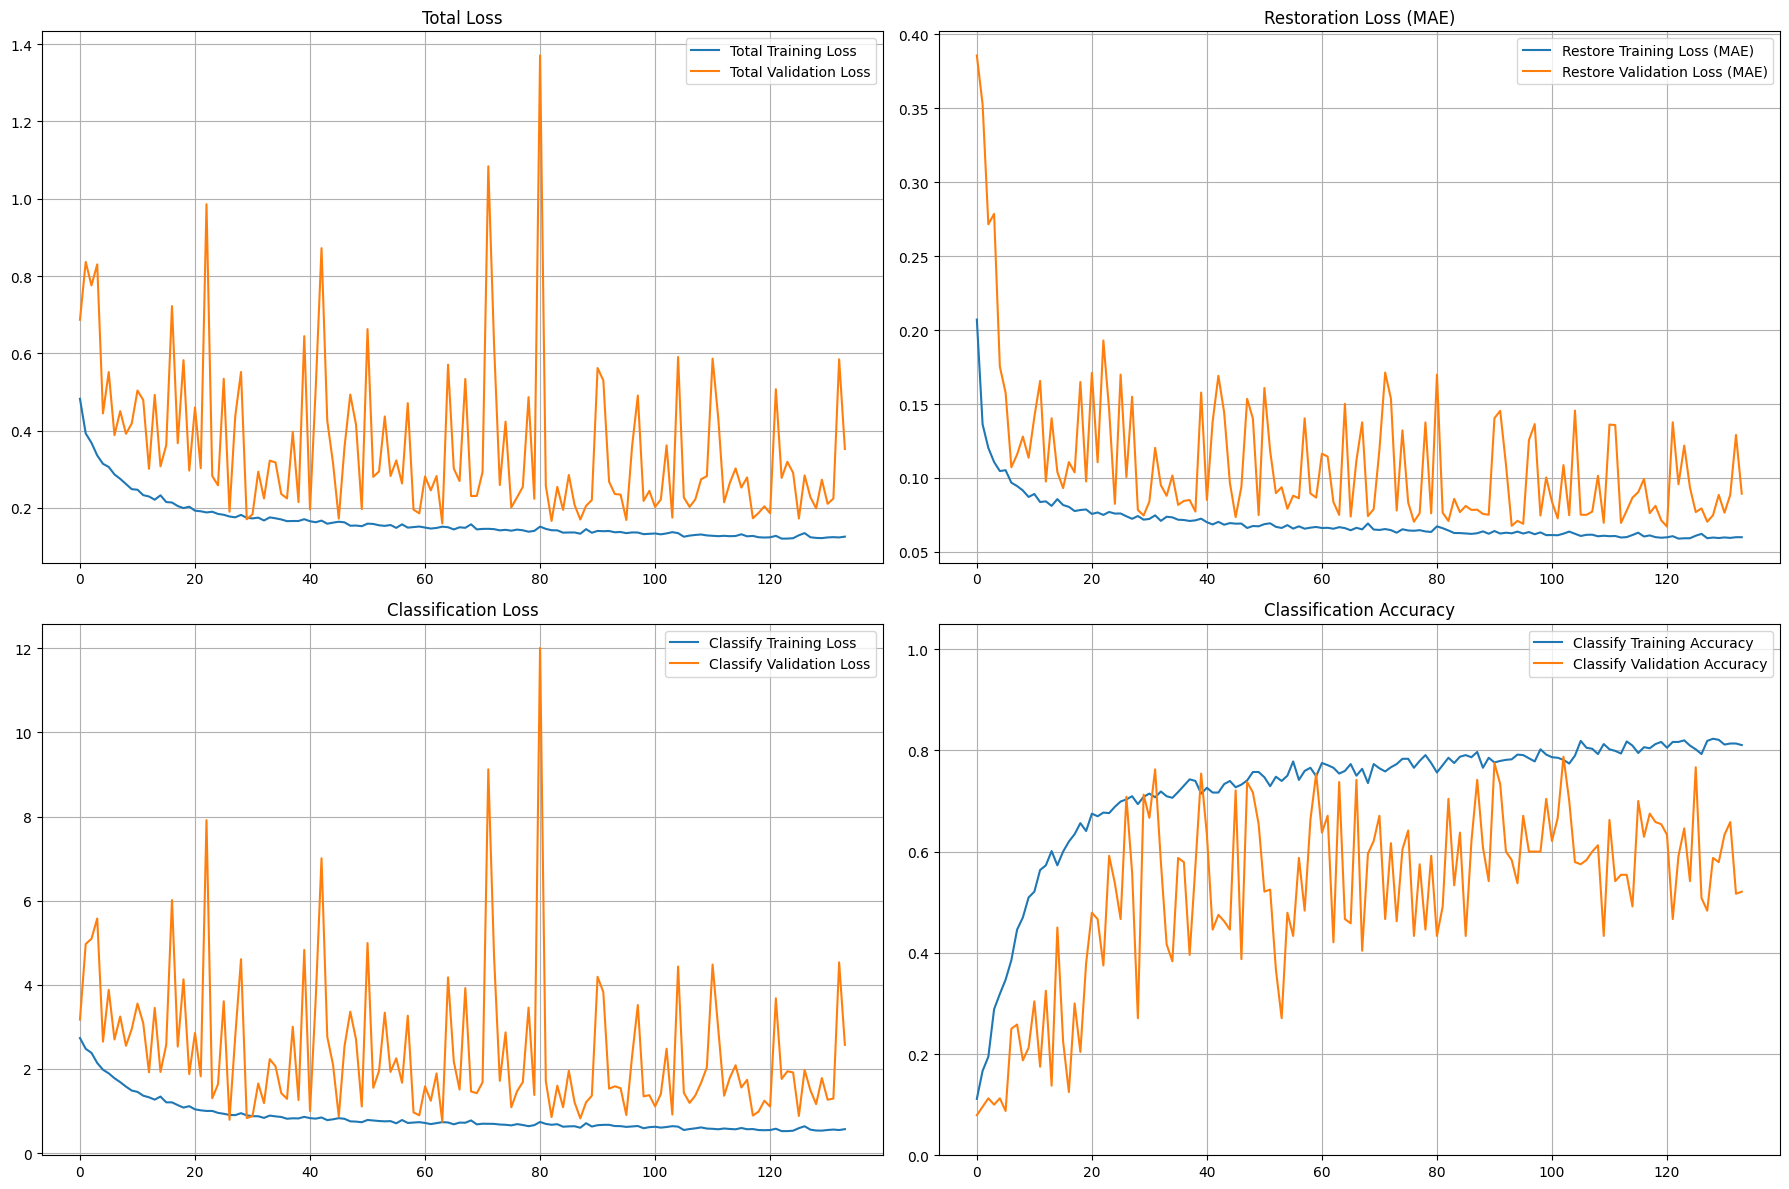

In [9]:
def plot_multitask_history(history_obj):
    """멀티태스크 모델의 학습 기록을 시각화합니다."""
    plt.figure(figsize=(18, 12))

    # Total Loss
    plt.subplot(2, 2, 1)
    plt.plot(history_obj.history['loss'], label='Total Training Loss')
    plt.plot(history_obj.history['val_loss'], label='Total Validation Loss')
    plt.title('Total Loss')
    plt.legend()
    plt.grid(True)

    # Restoration Loss
    plt.subplot(2, 2, 2)
    plt.plot(history_obj.history['restoration_output_loss'], label='Restore Training Loss (MAE)')
    plt.plot(history_obj.history['val_restoration_output_loss'], label='Restore Validation Loss (MAE)')
    plt.title('Restoration Loss (MAE)')
    plt.legend()
    plt.grid(True)

    # Classification Loss
    plt.subplot(2, 2, 3)
    plt.plot(history_obj.history['classification_output_loss'], label='Classify Training Loss')
    plt.plot(history_obj.history['val_classification_output_loss'], label='Classify Validation Loss')
    plt.title('Classification Loss')
    plt.legend()
    plt.grid(True)
    
    # Classification Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history_obj.history['classification_output_accuracy'], label='Classify Training Accuracy')
    plt.plot(history_obj.history['val_classification_output_accuracy'], label='Classify Validation Accuracy')
    plt.title('Classification Accuracy')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 학습이 끝난 history 객체를 사용하여 그래프 그리기
plot_multitask_history(history)

Loading the best model saved during training...

--- Best Model Performance on Validation Set ---
Total Validation Loss: 0.1599
Validation Restoration Loss (MAE): 0.0750
Validation Classification Loss: 0.7445
Validation Classification Accuracy: 73.75%

--- Generating Confusion Matrix ---
8/8 [==============================] - 1s 112ms/step
                          precision    recall  f1-score   support

  Mona Lisa 0 (Original)       0.82      0.82      0.82        22
  Mona Lisa 1 (Parody_1)       0.67      1.00      0.80        20
  Mona Lisa 2 (Parody_2)       1.00      0.54      0.70        26
  Mona Lisa 3 (Parody_3)       1.00      0.86      0.93        22
  Mona Lisa 4 (Parody_4)       0.90      0.64      0.75        14
  Mona Lisa 5 (Parody_5)       0.44      0.68      0.54        22
  Mona Lisa 6 (Parody_6)       1.00      0.65      0.79        23
  Mona Lisa 7 (Parody_7)       0.86      0.80      0.83        15
  Mona Lisa 8 (Parody_8)       0.44      1.00      0.61        

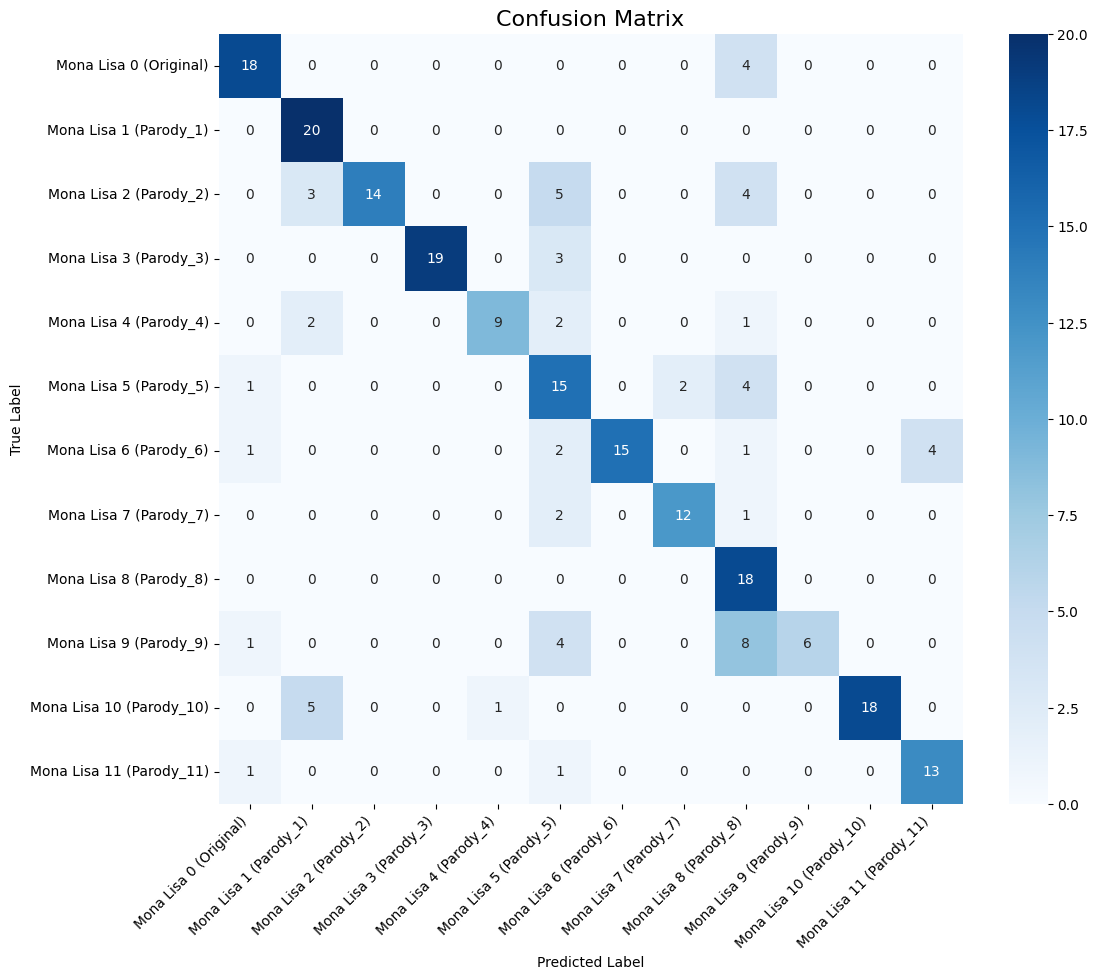

NameError: name 'performance_results' is not defined

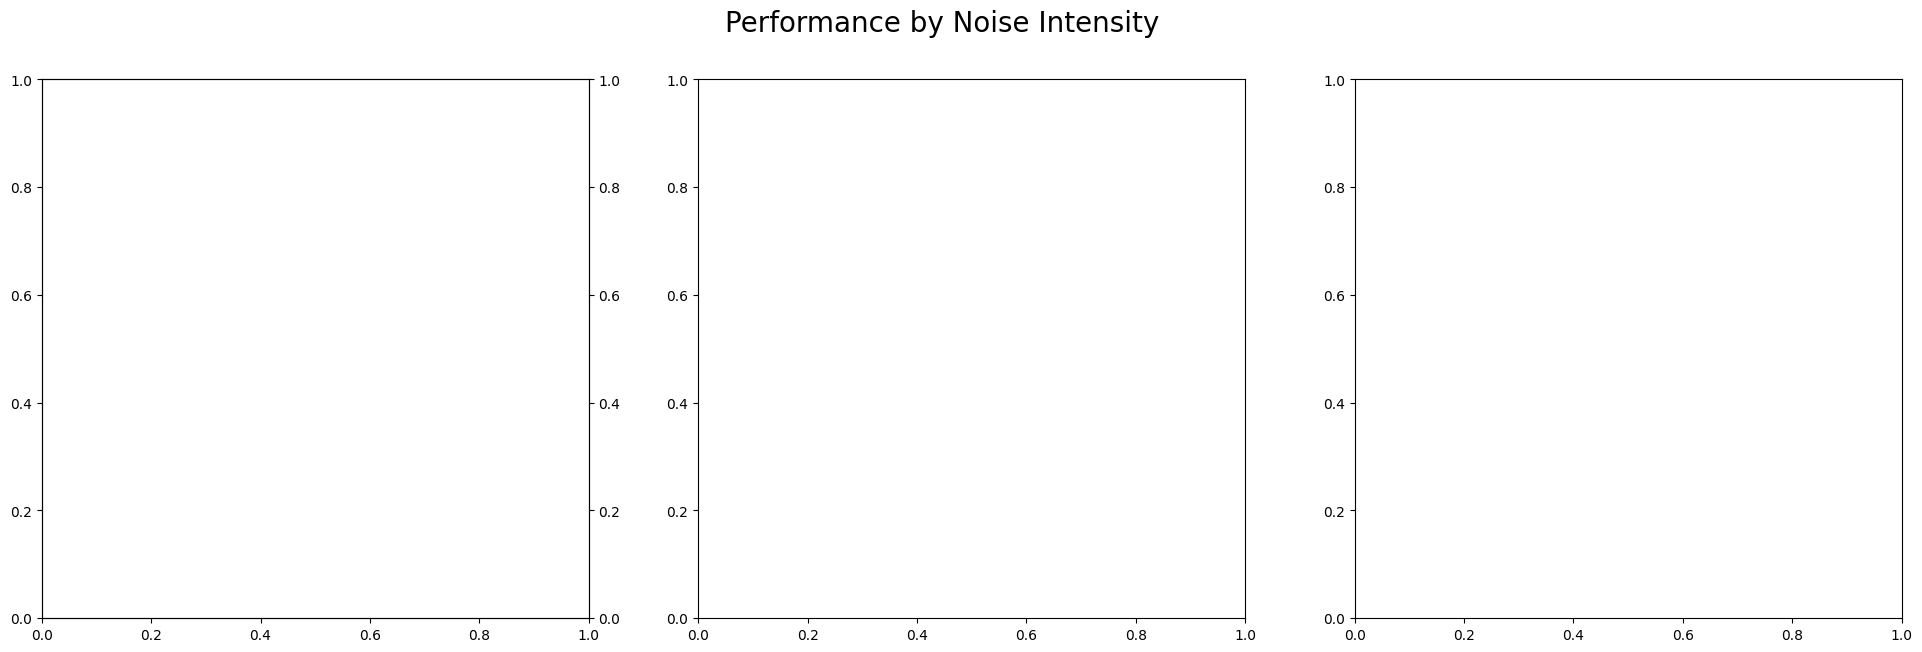

In [10]:
# --- 7-1. 최고 성능 모델 로드 및 최종 평가 ---
print("Loading the best model saved during training...")
try:
    # ---!!! 파일 이름 수정 !!!---
    best_model = tf.keras.models.load_model('best_conditional_model.keras')
    
    # ---!!! 변수 이름 및 구조 수정 !!!---
    # Validation set 준비 (올바른 변수 이름 사용)
    split_index = int(len(X_noisy_data) * 0.8)
    
    X_val = [X_noisy_data[split_index:], X_noise_map_data[split_index:]]
    y_val_restore = y_restore_data[split_index:]
    y_val_classify = y_classify_data[split_index:]
    # --------------------------------

    # 최종 평가
    results = best_model.evaluate(X_val, [y_val_restore, y_val_classify], verbose=0)
    
    print("\n--- Best Model Performance on Validation Set ---")
    print(f"Total Validation Loss: {results[0]:.4f}")
    print(f"Validation Restoration Loss (MAE): {results[1]:.4f}")
    print(f"Validation Classification Loss: {results[2]:.4f}")
    print(f"Validation Classification Accuracy: {results[3]*100:.2f}%")

except Exception as e:
    print(f"Could not load the best model. Error: {e}")


# --- 7-2. Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
y_pred_restore, y_pred_classify_probs = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred_classify_probs, axis=1)

print(classification_report(y_val_classify, y_pred_classes, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_val_classify, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# --- 3. 성능 곡선 시각화 ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Performance by Noise Intensity', fontsize=20)

# 가우시안 노이즈
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(performance_results['gaussian']['levels'], performance_results['gaussian']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax1_twin.plot(performance_results['gaussian']['levels'], performance_results['gaussian']['accuracy'], 's--', color='r', label='Accuracy')
ax1.set_xlabel('Gaussian Noise (SNR in dB)')
ax1.set_ylabel('Restoration PSNR (dB)', color='b')
ax1_twin.set_ylabel('Classification Accuracy', color='r')
ax1.set_title('Gaussian Noise')
ax1.grid(True)
ax1.invert_xaxis() # SNR은 낮을수록 노이즈가 심하므로 x축 반전
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1_twin.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

# 솔트 앤 페퍼 노이즈
ax2 = axes[1]
ax2_twin = ax2.twinx()
ax2.plot(performance_results['salt_pepper']['levels'], performance_results['salt_pepper']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax2_twin.plot(performance_results['salt_pepper']['levels'], performance_results['salt_pepper']['accuracy'], 's--', color='r', label='Accuracy')
ax2.set_xlabel('Salt & Pepper Noise (Amount)')
ax2.set_title('Salt & Pepper Noise')
ax2.grid(True)

# 버스트 노이즈
ax3 = axes[2]
ax3_twin = ax3.twinx()
ax3.plot(performance_results['burst']['levels'], performance_results['burst']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax3_twin.plot(performance_results['burst']['levels'], performance_results['burst']['accuracy'], 's--', color='r', label='Accuracy')
ax3.set_xlabel('Burst Noise (Size Factor)')
ax3.set_title('Burst Noise')
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Part 8: Generating Performance Curve Data ---

Evaluating performance for gaussian noise...


Testing gaussian levels: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]



Evaluating performance for salt_pepper noise...


Testing salt_pepper levels: 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]



Evaluating performance for burst noise...


Testing burst levels: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]



--- Generating Performance Curves ---


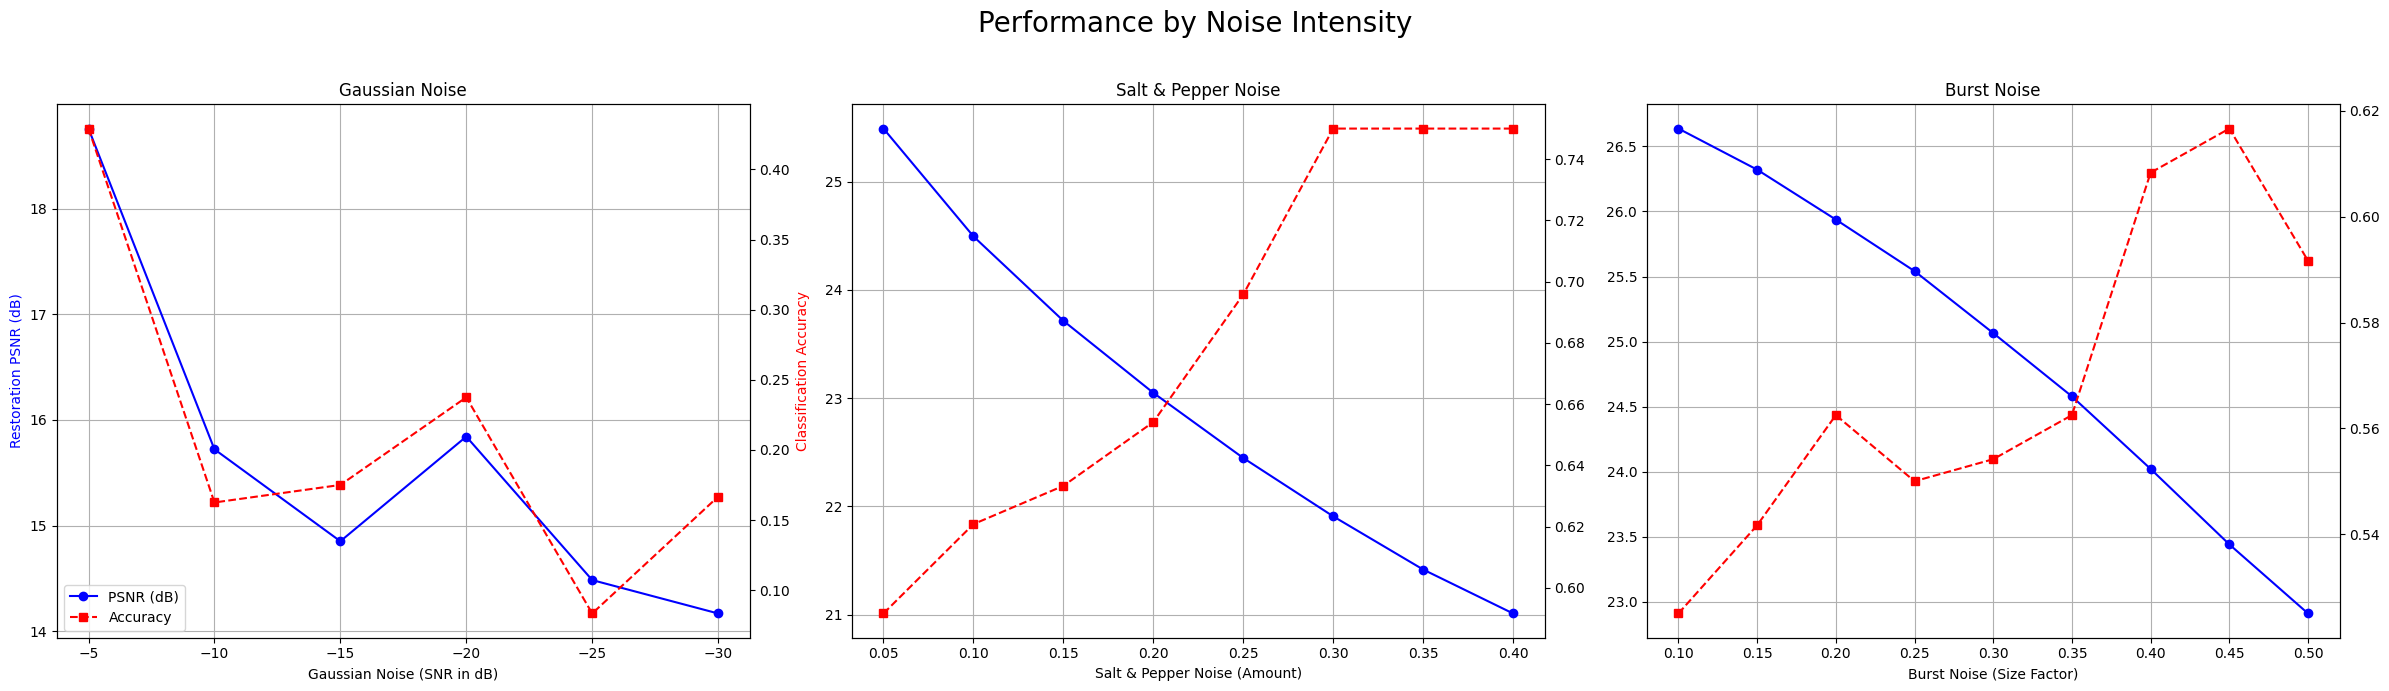

In [ ]:
# ==============================================================================
# Part 8: 노이즈 강도별 성능 곡선 분석
# ==============================================================================
print("\n--- Part 8: Generating Performance Curve Data ---")

# --- 1. 테스트할 노이즈 강도 레벨 정의 ---
gaussian_snr_levels = np.arange(-5, -31, -5) # [-5, -10, -15, -20, -25, -30]
sp_amount_levels = np.arange(0.05, 0.41, 0.05) # [0.05, 0.1, ..., 0.4]
burst_size_levels = np.arange(0.1, 0.51, 0.05) # [0.1, 0.15, ..., 0.5]

# --- 2. 결과를 저장할 딕셔너리 생성 (이 부분이 누락되었습니다!) ---
performance_results = {
    'gaussian': {'levels': gaussian_snr_levels, 'psnr': [], 'accuracy': []},
    'salt_pepper': {'levels': sp_amount_levels, 'psnr': [], 'accuracy': []},
    'burst': {'levels': burst_size_levels, 'psnr': [], 'accuracy': []},
}

# --- 3. 각 노이즈 유형 및 강도별로 성능 측정 (이 부분이 누락되었습니다!) ---
num_test_samples_per_class = 20 # 테스트셋 크기 (클래스당 샘플 수)

# PSNR 계산 함수 (혹시 모르니 다시 정의)
def calculate_psnr(img1, img2):
    return tf.image.psnr(img1[..., tf.newaxis], img2[..., tf.newaxis], max_val=1.0).numpy()

for noise_type, data in performance_results.items():
    print(f"\nEvaluating performance for {noise_type} noise...")
    
    for level in tqdm(data['levels'], desc=f"Testing {noise_type} levels"):
        # a. 현재 레벨의 노이즈로 테스트셋 생성
        X_test_noisy, X_test_map, y_test_clean, y_test_class = [], [], [], []
        for class_idx, original_img in enumerate(original_images):
            for _ in range(num_test_samples_per_class):
                sigma_eq = 0.0
                if noise_type == 'gaussian':
                    noisy_img = add_noise_snr_np(original_img, snr_db=level)
                    # SNR to sigma conversion (approximate)
                    signal_power = np.mean(np.square(original_img))
                    noise_power = signal_power / (10 ** (level / 10.0))
                    sigma_eq = np.sqrt(noise_power) * 255
                elif noise_type == 'salt_pepper':
                    noisy_img = add_salt_and_pepper_noise(original_img, amount=level)
                    sigma_eq = level * 50
                elif noise_type == 'burst':
                    noisy_img = add_burst_noise(original_img, burst_size_factor=level, intensity=1.0)
                    sigma_eq = level * 50
                
                noise_map = np.full(original_img.shape, sigma_eq / 50.0, dtype=np.float32)
                
                X_test_noisy.append(noisy_img)
                X_test_map.append(noise_map)
                y_test_clean.append(original_img)
                y_test_class.append(class_idx)

        X_test = [np.array(X_test_noisy)[..., np.newaxis], np.array(X_test_map)[..., np.newaxis]]
        y_test_clean = np.array(y_test_clean)[..., np.newaxis]
        y_test_class = np.array(y_test_class)
        
        # b. 모델 예측 수행
        restored_outputs, classification_outputs = best_model.predict(X_test, verbose=0)
        
        # c. 복원 성능(PSNR) 계산
        avg_psnr = calculate_psnr(y_test_clean, restored_outputs).mean()
        data['psnr'].append(avg_psnr)
        
        # d. 분류 성능(Accuracy) 계산
        predicted_classes = np.argmax(classification_outputs, axis=1)
        accuracy = np.mean(predicted_classes == y_test_class)
        data['accuracy'].append(accuracy)

# --- 4. 성능 곡선 시각화 (이제 performance_results가 존재합니다!) ---
print("\n--- Generating Performance Curves ---")
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Performance by Noise Intensity', fontsize=20)

# 가우시안 노이즈
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(performance_results['gaussian']['levels'], performance_results['gaussian']['psnr'], 'o-', color='b', label='PSNR (dB)')
ax1_twin.plot(performance_results['gaussian']['levels'], performance_results['gaussian']['accuracy'], 's--', color='r', label='Accuracy')
ax1.set_xlabel('Gaussian Noise (SNR in dB)')
ax1.set_ylabel('Restoration PSNR (dB)', color='b')
ax1_twin.set_ylabel('Classification Accuracy', color='r')
ax1.set_title('Gaussian Noise')
ax1.grid(True)
ax1.invert_xaxis()
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1_twin.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

# 솔트 앤 페퍼 노이즈
ax2 = axes[1]
ax2_twin = ax2.twinx()
ax2.plot(performance_results['salt_pepper']['levels'], performance_results['salt_pepper']['psnr'], 'o-', color='b')
ax2_twin.plot(performance_results['salt_pepper']['levels'], performance_results['salt_pepper']['accuracy'], 's--', color='r')
ax2.set_xlabel('Salt & Pepper Noise (Amount)')
ax2.set_title('Salt & Pepper Noise')
ax2.grid(True)

# 버스트 노이즈
ax3 = axes[2]
ax3_twin = ax3.twinx()
ax3.plot(performance_results['burst']['levels'], performance_results['burst']['psnr'], 'o-', color='b')
ax3_twin.plot(performance_results['burst']['levels'], performance_results['burst']['accuracy'], 's--', color='r')
ax3.set_xlabel('Burst Noise (Size Factor)')
ax3.set_title('Burst Noise')
ax3.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()